In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

import scipy.io

from time import time

from tqdm.notebook import tqdm

In [2]:
np.random.normal((2, 100)).flatten()

array([ 2.26498657, 98.51201859])

In [2]:
class BioNet(nn.Module):
    def __init__(self,
                 weights : torch.Tensor,
                 output_dim : int,
                 n : float = 4.5,
                 beta : float =.01):
        
        """
        Simple MNIST classifier initialized with weights from the unsupervised (bio)learning algorithm for the first layer.
        
        Parameters
        ----------
        weights : torch.Tensor of shape (output_dim, input_dim), where input_dim = 28*28 for the MNIST dataset
            Weights computed from unsupervised learning.
        output_dim : int
            Number of classes (10 for MNIST)
        n : float
            Exponent of ReLU
        beta : float
            "Inverse temperature" for tanh activation in the top layer (See equation 1 in [10]).
        """
        
        super().__init__()
        self.weights = torch.t(weights) #shape (output_dim, input_dim) -> (input_dim, output_dim)
        #[Because batch_size is the first dimension of inputs, and so it is convenient to transpose the weights
        #so that a single matrix multiplication works for the entire batch]
        
        self.n = n
        self.beta = beta
        # The .size method is equivalent to .shape in numpy
        self.top = nn.Linear(in_features = weights.size(0), out_features = output_dim, bias=False)
        
    def forward(self, inputs : torch.Tensor): # vᵢ: (batch_sz, img_sz)
        """
        Parameters
        ----------
        inputs : torch.Tensor of shape (batch_size, input_dim)
            Batch of input values
        """
        
        out = torch.matmul(inputs, self.weights) 
        out = F.relu(out) ** self.n
        out = self.top(out)
        out = torch.tanh(self.beta * out)
        
        return out
    
class BioLoss(nn.Module):
    """Loss introduced in eq. 12 of [1]
    
    [1]: "Unsupervised learning by competing hidden units", D. Krotov, J. J. Hopfield, 2019, 
         https://www.pnas.org/content/116/16/7723
    """
    
    def __init__(self,
                 output_dim : int = 10,
                 m : int = 6):
        
        super().__init__()
        
        self.output_dim = output_dim
        self.m = m

    def forward(self, predicted, true_val): 
        one_hot = torch.eye(self.output_dim, dtype=torch.float, device=predicted.device)[true_val]
        #Convert true values to one hot encoding
        one_hot[one_hot == 0] = -1 #Substitute 0s with -1 (spin-like one hot encoding)
        
        loss = (predicted - one_hot).abs() ** self.m
        
        return torch.sum(loss)

Equation for the loss defined in the `BioLoss` class above,

$$
C \quad = \quad \sum_{examples} \sum_{\alpha = 1}^{N_c}|c_{\alpha} - t_{\alpha}|^m
$$

where $t_{\alpha}$ are the one hot encoded labels (composed of $\pm$ 1) values. $c_{\alpha}$ are instead the predicted values.

In [3]:
def run_test(train_X, train_y, test_X, test_y, model, epochs, loss, batch_size=64, lr=1e-3, verbose=0):
    #From https://github.com/gatapia/unsupervised_bio_classifier/blob/master/src/bio_learn2.py
    #(Standard training code)
    
    start = time()
    train_ds = TensorDataset(train_X, train_y)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = TensorDataset(test_X, test_y)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        
    optimizer = Adam(model.parameters(), lr=lr)    
    #create_supervised_trainer is a factory function (a function that returns a new object) for creating a trainer for supervised models
    trainer = create_supervised_trainer(model, optimizer, loss)
    evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss)})
    
    pbar = tqdm(initial=0, leave=False, total=epochs, desc=f"ITERATION") #Progress bar
    
    train_err = []
    test_err  = []
    
    # Basic usage of ignite's create_supervised_trainer function

    #EPOCH_COMPLETED : triggered when the epoch is ended. Note that this is triggered even when terminate_epoch() is called.
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch(trainer):
        evaluator.run(train_dl)
        metrics = evaluator.state.metrics
        train_acc = metrics['accuracy']
        
        evaluator.run(test_dl)
        metrics = evaluator.state.metrics
        test_acc = metrics['accuracy']
        
        train_err.append( 100 * (1. - train_acc) )
        test_err.append( 100 * (1. - test_acc ) )
        
        pbar.desc = f"ITERATION - accuracy (train): {train_acc:.3f} - accuracy (test) : {test_acc:.3f}"
        pbar.update(1)

    # COMPLETED : triggered when engine’s run is completed
    @trainer.on(Events.COMPLETED)
    def log_complete(engine):
        evaluator.run(test_dl)        
        print("Final Accuracy: {:.2f} Took: {:.0f}s".format(evaluator.state.metrics['accuracy'], time() - start))

    trainer.run(train_dl, max_epochs=epochs) 
    
    return train_err, test_err

In [4]:
def get_data(data_type):
    mat = scipy.io.loadmat('../../data/project/MNIST/mnist_all.mat')
    X=torch.zeros((0, 28 * 28), dtype=torch.float)
    y=torch.zeros(0, dtype=torch.long)
    for i in range(10): 
        X_i = torch.from_numpy(mat[data_type + str(i)].astype(np.float64)).float()
        # cat concatenates a given sequence of tensors
        X = torch.cat((X, X_i))
        y_i = torch.full(size=(len(X_i),), fill_value=i, dtype=torch.long)
        y = torch.cat((y, y_i))
    return X / 255.0, y

In [5]:
weights = torch.load("../../data/project/weightsUnsupervised/unsupervisedWeights") #Load saved weights

In [6]:
weights.detach().numpy().shape

(2000, 784)

In [7]:
(train_X, train_y), (test_X, test_y) = get_data('train'), get_data('test')
print('train_data, test_data:', train_X.shape, train_y.shape, test_X.shape, test_y.shape) #Load dataset

train_data, test_data: torch.Size([60000, 784]) torch.Size([60000]) torch.Size([10000, 784]) torch.Size([10000])


In [8]:
#Supervised training of top layer
n_classes = 10
model = BioNet(weights.float(), n_classes, beta=.001)#.cuda() #Remove .cuda() everywhere in this line to train on CPU only
train_err, test_err = run_test(train_X, train_y, test_X, test_y, model, epochs=30, loss=BioLoss(n_classes), batch_size=100, lr=1e-4)  

ITERATION:   0%|          | 0/30 [00:00<?, ?it/s]

Final Accuracy: 0.97 Took: 1131s


In [14]:
test_err[-1]

3.159999999999996

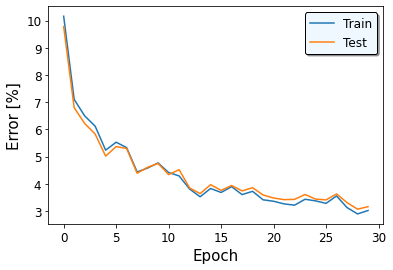

In [21]:
import matplotlib.pyplot as plt
#from mpl2latex import mpl2latex, latex_figsize

#with mpl2latex(True):
fig = plt.figure(figsize=(6, 4))

epochs = np.arange(len(train_err))
plt.plot(epochs, train_err, label="Train")
plt.plot(epochs, test_err, label="Test")

plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Error [%]", fontsize = 15)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(facecolor='aliceblue', framealpha=1, shadow = True, edgecolor = 'black', fontsize = 12)
plt.show()
fig.savefig("../../data/project/plots/supervised_learning.pdf", transparent=True, bbox_inches='tight')

For the implementation of the concolutional algorithm we redirect the interested reader to the [convolution notebook](./convolutionNotebook.ipynb)